# Pipeline of the anomaly detection on the SKAB using combined Hotelling's ($T^2$) and Q (SPE) statistics based on the PCA

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [ ]:
# libraries importing
import sys
import warnings

import pandas as pd

sys.path.append("..")
from core.t2 import T2
from core.metrics import chp_score
from core.utils import load_preprocess_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [ ]:
Xy_traintest_list = load_preprocess_skab()

## Method

### Method initialization

In [ ]:
# classifier initializing
model = T2(scaling=True, using_pca=True)

In [ ]:
# inference
predicted_outlier, predicted_cp = [], []
true_outlier, true_cp = [], []
for X_train, X_test, y_train, y_test in Xy_traintest_list:
    # classifier fitting
    model.fit(X_train)

    # results predicting
    model.predict(
        X_test,
        window_size=5,
        plot_fig=False,
    )
    prediction = pd.Series(
        (
            (model.t2["T2"].values > model.t2_ucl)
            | (model.q["Q"] > model.q_ucl)
        ).astype(int),
        index=X_test.index,
    ).fillna(0)

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

    true_outlier.append(y_test["anomaly"])
    true_cp.append(y_test["changepoint"])

### Results visualization

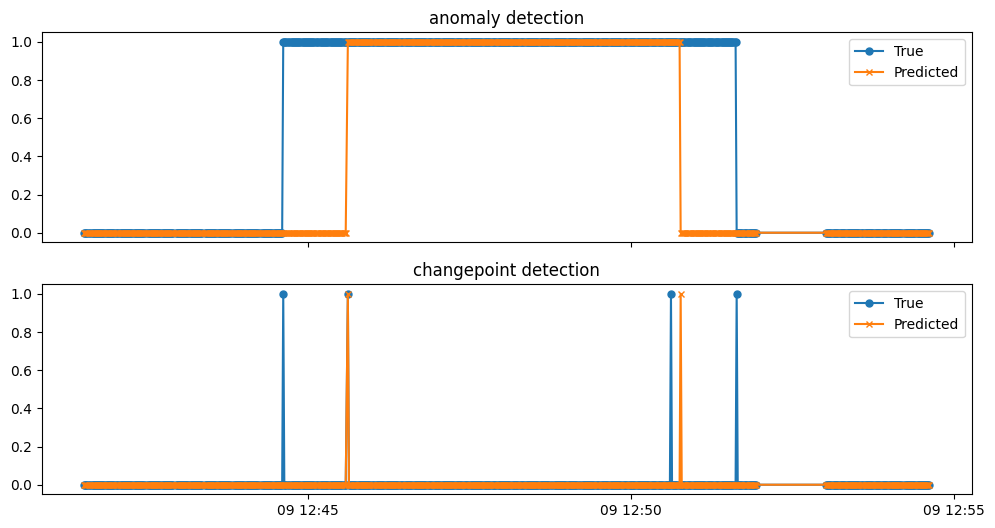

In [ ]:
# [donotremove]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

In [ ]:
import pickle

pickle.dump(
    predicted_outlier,
    open(f"../results/results-{model.__class__.__name__}-q.pkl", "wb"),
)

### Binary classification (outlier detection) metrics

In [ ]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 26.62 %
Missing Alarm Rate 24.92 %
F1 metric 0.76


### Changepoint detection metrics

In [ ]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    window_width="60s",
    anomaly_window_destination="righter",
)

Amount of true anomalies 127
A number of missed CPs = 72
A number of FPs = 232
Average time 0 days 00:00:20.927272727


In [ ]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="60s",
    anomaly_window_destination="righter",
)

Standard  -  25.35
LowFP  -  14.51
LowFN  -  31.33
